# 悉尼天气预测

通过对悉尼当天的各种气象因素（湿度，压力，风向等）对第二天是否下雨，降水量多少进行预测。

数据集来源：https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

## 导入所需库

In [69]:
import pandas as pd
pd.set_option('precision', 7)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
pd.options.display.max_rows = None
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectKBest,f_regression,f_classif,chi2
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import warnings
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

## 数据清理

读取数据集，检查数据类型以及缺失值数量。这里只读取悉尼天气数据，因此筛选掉其他城市的气象数据。

In [2]:
weather=pd.read_csv('weatheraus.csv')
weather_sydney=weather[weather['Location']=='Sydney']

In [3]:
weather_sydney.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
29497,2008-02-01,Sydney,19.5,22.4,15.6,6.2,0.0,NaN,NaN,S,...,84.0,1017.6,1017.4,8.0,8.0,20.7,20.9,Yes,6.0,Yes
29498,2008-02-02,Sydney,19.5,25.6,6.0,3.4,2.7,NaN,NaN,W,...,73.0,1017.9,1016.4,7.0,7.0,22.4,24.8,Yes,6.6,Yes
29499,2008-02-03,Sydney,21.6,24.5,6.6,2.4,0.1,NaN,NaN,ESE,...,86.0,1016.7,1015.6,7.0,8.0,23.5,23.0,Yes,18.8,Yes
29500,2008-02-04,Sydney,20.2,22.8,18.8,2.2,0.0,NaN,NaN,NNE,...,90.0,1014.2,1011.8,8.0,8.0,21.4,20.9,Yes,77.4,Yes
29501,2008-02-05,Sydney,19.7,25.7,77.4,NaN,0.0,NaN,NaN,NNE,...,74.0,1008.3,1004.8,8.0,8.0,22.5,25.5,Yes,1.6,Yes


In [4]:
weather_sydney.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3337 entries, 29497 to 32833
Data columns (total 24 columns):
Date             3337 non-null object
Location         3337 non-null object
MinTemp          3334 non-null float64
MaxTemp          3335 non-null float64
Rainfall         3331 non-null float64
Evaporation      3286 non-null float64
Sunshine         3321 non-null float64
WindGustDir      2301 non-null object
WindGustSpeed    2301 non-null float64
WindDir9am       3281 non-null object
WindDir3pm       3304 non-null object
WindSpeed9am     3311 non-null float64
WindSpeed3pm     3312 non-null float64
Humidity9am      3323 non-null float64
Humidity3pm      3324 non-null float64
Pressure9am      3317 non-null float64
Pressure3pm      3318 non-null float64
Cloud9am         2771 non-null float64
Cloud3pm         2776 non-null float64
Temp9am          3333 non-null float64
Temp3pm          3333 non-null float64
RainToday        3331 non-null object
RISK_MM          3337 non-null float

In [5]:
weather_sydney.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RISK_MM
count,3334.0000000,3335.0000000,3331.0000000,3286.0000000,3321.0000000,2301.0000000,3311.0000000,3312.0000000,3323.0000000,3324.0000000,3317.0000000,3318.000000,2771.0000000,2776.0000000,3333.0000000,3333.0000000,3337.0000000
mean,14.8650570,23.0023388,3.3302312,5.1874315,7.1793737,41.7614081,15.0706735,19.3354469,68.2290099,54.6991576,1018.3461562,1016.018774,4.1815229,4.2186599,17.8197420,21.5333333,3.3198681
std,4.5536413,4.4946379,9.8951723,2.7774067,3.8108863,13.0075231,7.0797243,7.4825543,15.0853554,16.2935304,7.0215712,7.032211,2.7495778,2.6418853,4.8971769,4.3037368,9.8850657
min,4.3000000,11.7000000,0.0000000,0.0000000,0.0000000,17.0000000,0.0000000,0.0000000,19.0000000,10.0000000,986.7000000,989.800000,0.0000000,0.0000000,6.4000000,10.2000000,0.0000000
25%,11.0000000,19.6000000,0.0000000,3.2000000,4.3000000,31.0000000,9.0000000,15.0000000,58.0000000,44.0000000,1013.7000000,1011.300000,1.0000000,1.0000000,13.8000000,18.4000000,0.0000000
50%,14.9000000,22.8000000,0.0000000,4.8000000,8.3000000,41.0000000,15.0000000,19.0000000,69.0000000,56.0000000,1018.6000000,1016.300000,5.0000000,4.0000000,18.2000000,21.3000000,0.0000000
75%,18.7000000,26.0000000,1.4000000,7.0000000,10.2000000,50.0000000,20.0000000,24.0000000,80.0000000,65.0000000,1023.1000000,1020.800000,7.0000000,7.0000000,21.7000000,24.5000000,1.4000000
max,27.6000000,45.8000000,119.4000000,18.4000000,13.6000000,96.0000000,54.0000000,57.0000000,100.0000000,99.0000000,1039.0000000,1036.700000,9.0000000,8.0000000,36.5000000,44.7000000,119.4000000


从info()中可看出缺失值主要存在于每日最强风的风力与风速，以及云层厚度。接下来检查数据集中是否有重复数据，例如同一天的气象数据出现了多次。

In [6]:
weather_sydney=weather_sydney.drop_duplicates(subset='Date', keep='first', inplace=False)
weather_sydney.shape[0]

3337

数据集依旧是3337行，所以数据集中并没有重复日期。

预测变量‘RainToday’（今日是否下雨），‘Rainfall’（今日降水量）中各有6个缺失值，但是此变量值可由上一天的‘RainTomorrow’（明日是否下雨）及‘RISK_MM’（明日降水量）推测出，所以‘RainToday’与‘Rainfall’的缺失值可以用此法填补。

In [7]:
for index in weather_sydney.index:
    if pd.isnull(weather_sydney.loc[index,'RainToday']):
        weather_sydney.loc[index,['RainToday']]=weather_sydney.loc[index-1,['RainTomorrow']][0]
    if pd.isnull(weather_sydney.loc[index,'Rainfall']):
        weather_sydney.loc[index,['Rainfall']]=weather_sydney.loc[index-1,['RISK_MM']][0]

对于其余的缺失值我们选择将其所在行删除，最后剩余1692行数据。之后剔除不需要的列‘Date’，‘Location’，‘RainToday’，‘RainTomorrow’。

In [8]:
weather_sydney.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3337 entries, 29497 to 32833
Data columns (total 24 columns):
Date             3337 non-null object
Location         3337 non-null object
MinTemp          3334 non-null float64
MaxTemp          3335 non-null float64
Rainfall         3337 non-null float64
Evaporation      3286 non-null float64
Sunshine         3321 non-null float64
WindGustDir      2301 non-null object
WindGustSpeed    2301 non-null float64
WindDir9am       3281 non-null object
WindDir3pm       3304 non-null object
WindSpeed9am     3311 non-null float64
WindSpeed3pm     3312 non-null float64
Humidity9am      3323 non-null float64
Humidity3pm      3324 non-null float64
Pressure9am      3317 non-null float64
Pressure3pm      3318 non-null float64
Cloud9am         2771 non-null float64
Cloud3pm         2776 non-null float64
Temp9am          3333 non-null float64
Temp3pm          3333 non-null float64
RainToday        3337 non-null object
RISK_MM          3337 non-null float

In [9]:
weather_sydney=weather_sydney.dropna()
weather_sydney=weather_sydney.drop(columns=['Date','Location'])

对于类别变量，我们将‘Yes’和‘No’统一转化为1和0，并将风向变量向量化，即独热编码。

In [10]:
weather_sydney2=weather_sydney

In [11]:
weather_sydney=weather_sydney.replace('Yes',1)
weather_sydney=weather_sydney.replace('No',0)
weather_sydney= pd.get_dummies(weather_sydney,columns = ['WindGustDir','WindDir9am','WindDir3pm'],drop_first=True)

## 基础分析

首先分析风向因素，这里选取第二天会下雨的数据（RainTomorrow=Yes），统计下雨前一天的风向分布。

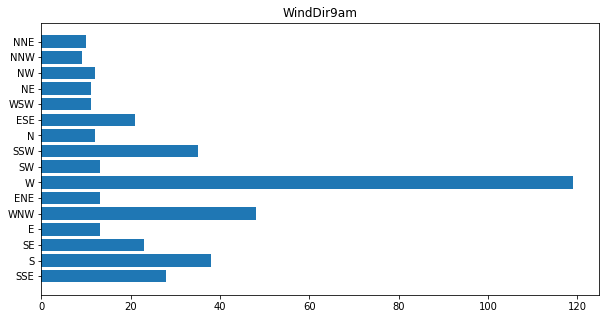

In [12]:
Wind=Counter(weather_sydney2[weather_sydney2['RainTomorrow']=='Yes']['WindDir9am'])
plt.figure(figsize=(10,5))
plt.barh(list(Wind.keys()),list(Wind.values()))
plt.title('WindDir9am')
plt.show()

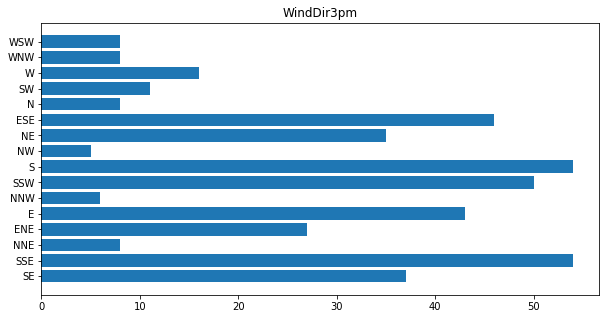

In [13]:
Wind=Counter(weather_sydney2[weather_sydney2['RainTomorrow']=='Yes']['WindDir3pm'])
plt.figure(figsize=(10,5))
plt.barh(list(Wind.keys()),list(Wind.values()))
plt.title('WindDir3pm')
plt.show()

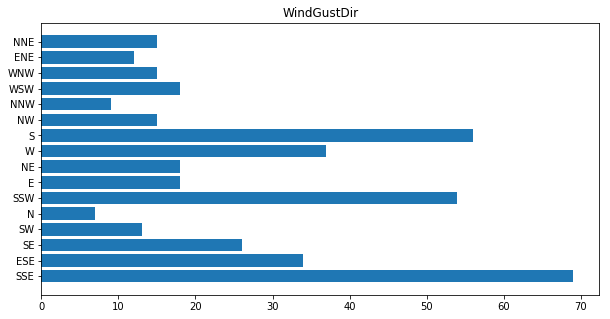

In [14]:
Wind=Counter(weather_sydney2[weather_sydney2['RainTomorrow']=='Yes']['WindGustDir'])
plt.figure(figsize=(10,5))
plt.barh(list(Wind.keys()),list(Wind.values()))
plt.title('WindGustDir')
plt.show()

可看出，如果上午9点风向为西风，下午3点风向大致为南风或东风，当日最大风为偏西南风时，第二天下雨情况居多。悉尼地处澳大利亚东南部，除了上午9点是情况，其他情况皆符合常理。

接下来分析云层厚度与降水的关系。

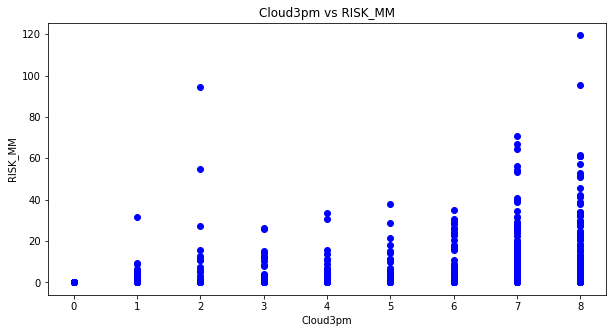

In [15]:
plt.figure(figsize=(10,5))
plt.scatter(weather_sydney2['Cloud3pm'],weather_sydney2['RISK_MM'],color='b')
plt.title('Cloud3pm vs RISK_MM')
plt.xlabel('Cloud3pm')
plt.ylabel('RISK_MM')
plt.show()

除了个别极端情况，总体上看随着云层厚度增加，第二天降水量有上升趋势。

湿度与降水也可观察到正相关关系。

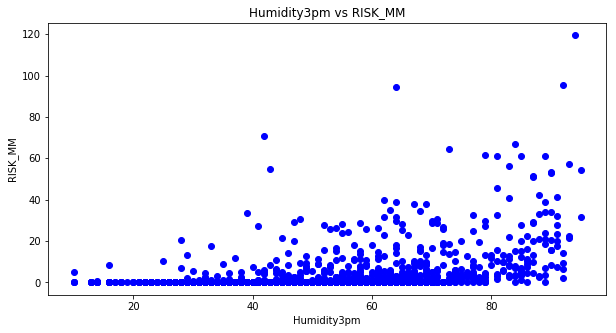

In [16]:
plt.figure(figsize=(10,5))
plt.scatter(weather_sydney2['Humidity3pm'],weather_sydney2['RISK_MM'],color='b')
plt.title('Humidity3pm vs RISK_MM')
plt.xlabel('Humidity3pm')
plt.ylabel('RISK_MM')
plt.show()

今天的降水量之间是否对明天的降水量有影响？由散点图看是呈负相关。

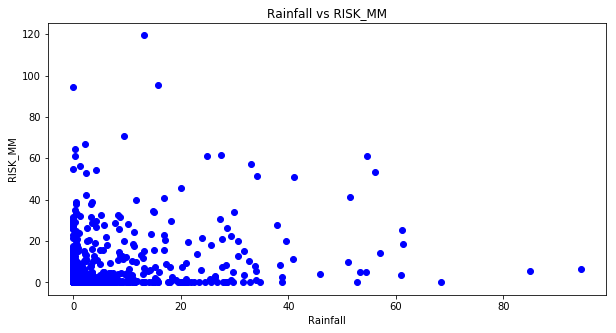

In [17]:
plt.figure(figsize=(10,5))
plt.scatter(weather_sydney2['Rainfall'],weather_sydney2['RISK_MM'],color='b')
plt.title('Rainfall vs RISK_MM')
plt.xlabel('Rainfall')
plt.ylabel('RISK_MM')
plt.show()

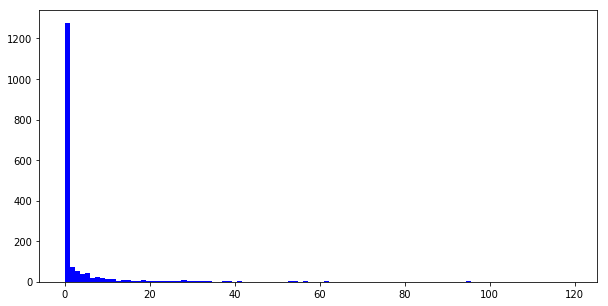

In [18]:
plt.figure(figsize=(10,5))
plt.hist(weather_sydney2['RISK_MM'],color='b',bins=100)

plt.show()

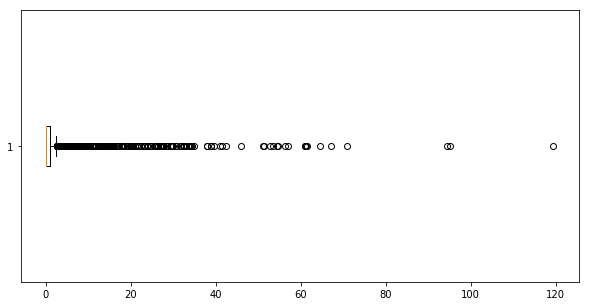

In [19]:
plt.figure(figsize=(10,5))
plt.boxplot(weather_sydney2['RISK_MM'],vert=False)
plt.show()

## 建模

由于我们只提取了悉尼当地的天气，因而大大损失了数据量。接下来考虑使用所有的数据进行学习，因此我们需要将可能影响下雨的地理因素：风向与风力去除。

In [20]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 24 columns):
Date             142193 non-null object
Location         142193 non-null object
MinTemp          141556 non-null float64
MaxTemp          141871 non-null float64
Rainfall         140787 non-null float64
Evaporation      81350 non-null float64
Sunshine         74377 non-null float64
WindGustDir      132863 non-null object
WindGustSpeed    132923 non-null float64
WindDir9am       132180 non-null object
WindDir3pm       138415 non-null object
WindSpeed9am     140845 non-null float64
WindSpeed3pm     139563 non-null float64
Humidity9am      140419 non-null float64
Humidity3pm      138583 non-null float64
Pressure9am      128179 non-null float64
Pressure3pm      128212 non-null float64
Cloud9am         88536 non-null float64
Cloud3pm         85099 non-null float64
Temp9am          141289 non-null float64
Temp3pm          139467 non-null float64
RainToday        140787 non-null obje

考虑某一气象站能获取的最基本的气象信息：

>一般氣象站測量的基本氣象要素包括溫度、濕度、風向、風速、氣壓和雨量。


因此我们的数据集只保留几项基本特征：温度，压力，湿度，风速，降水量。

In [21]:
weather_all=weather.drop(columns=['Date','Location','Evaporation','Sunshine','Cloud9am','Cloud3pm'])

In [22]:
weather_all.describe()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RISK_MM
count,141556.0000000,141871.0000000,140787.0000000,132923.0000000,140845.0000000,139563.0000000,140419.0000000,138583.0000000,128179.0000000,128212.0000000,141289.0000000,139467.0000000,142193.0000000
mean,12.1863997,23.2267842,2.3499741,39.9842917,14.0019880,18.6375759,68.8438103,51.4826061,1017.6537584,1015.2582035,16.9875086,21.6872350,2.3606816
std,6.4032827,7.1176181,8.4651729,13.5888008,8.8933371,8.8033450,19.0512925,20.7977718,7.1054757,7.0366768,6.4928383,6.9375939,8.4779691
min,-8.5000000,-4.8000000,0.0000000,6.0000000,0.0000000,0.0000000,0.0000000,0.0000000,980.5000000,977.1000000,-7.2000000,-5.4000000,0.0000000
25%,7.6000000,17.9000000,0.0000000,31.0000000,7.0000000,13.0000000,57.0000000,37.0000000,1012.9000000,1010.4000000,12.3000000,16.6000000,0.0000000
50%,12.0000000,22.6000000,0.0000000,39.0000000,13.0000000,19.0000000,70.0000000,52.0000000,1017.6000000,1015.2000000,16.7000000,21.1000000,0.0000000
75%,16.8000000,28.2000000,0.8000000,48.0000000,19.0000000,24.0000000,83.0000000,66.0000000,1022.4000000,1020.0000000,21.6000000,26.4000000,0.8000000
max,33.9000000,48.1000000,371.0000000,135.0000000,130.0000000,87.0000000,100.0000000,100.0000000,1041.0000000,1039.6000000,40.2000000,46.7000000,371.0000000


样本足够，我们将带缺失值的样本去除

In [23]:
weather_all=weather_all.dropna()

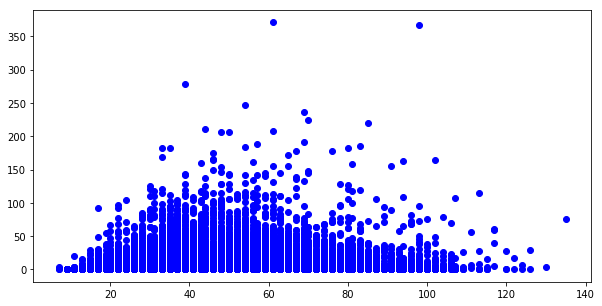

In [24]:
plt.figure(figsize=(10,5))
plt.scatter(weather_all['WindGustSpeed'],weather_all['RISK_MM'],color='b')
plt.show()

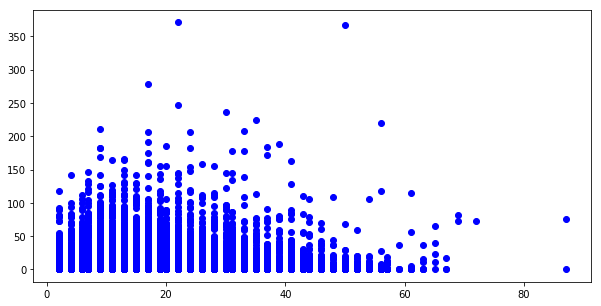

In [25]:
plt.figure(figsize=(10,5))
plt.scatter(weather_all['WindSpeed9am'],weather_all['RISK_MM'],color='b')
plt.show()

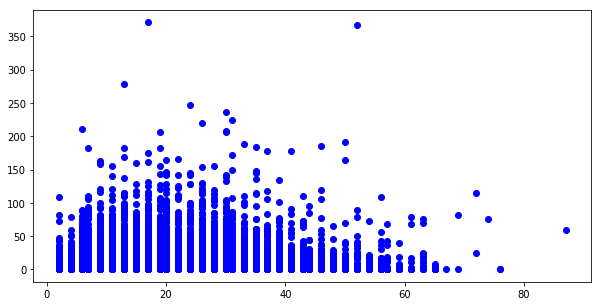

In [26]:
plt.figure(figsize=(10,5))
plt.scatter(weather_all['WindSpeed3pm'],weather_all['RISK_MM'],color='b')
plt.show()

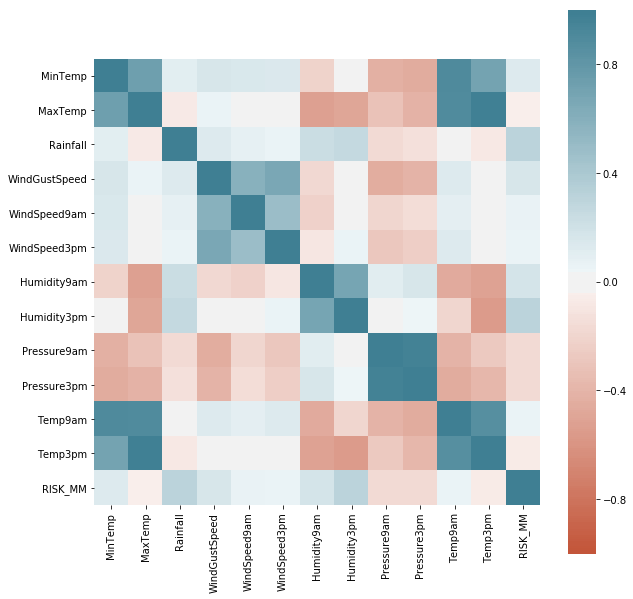

In [27]:
plt.figure(figsize=(10,10))
sns.heatmap(weather_all.corr(), vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True)
plt.show()

In [28]:
weather_all=weather_all.drop(columns=['WindGustDir','WindGustSpeed','WindDir9am','WindDir3pm','WindSpeed9am','WindSpeed3pm'])

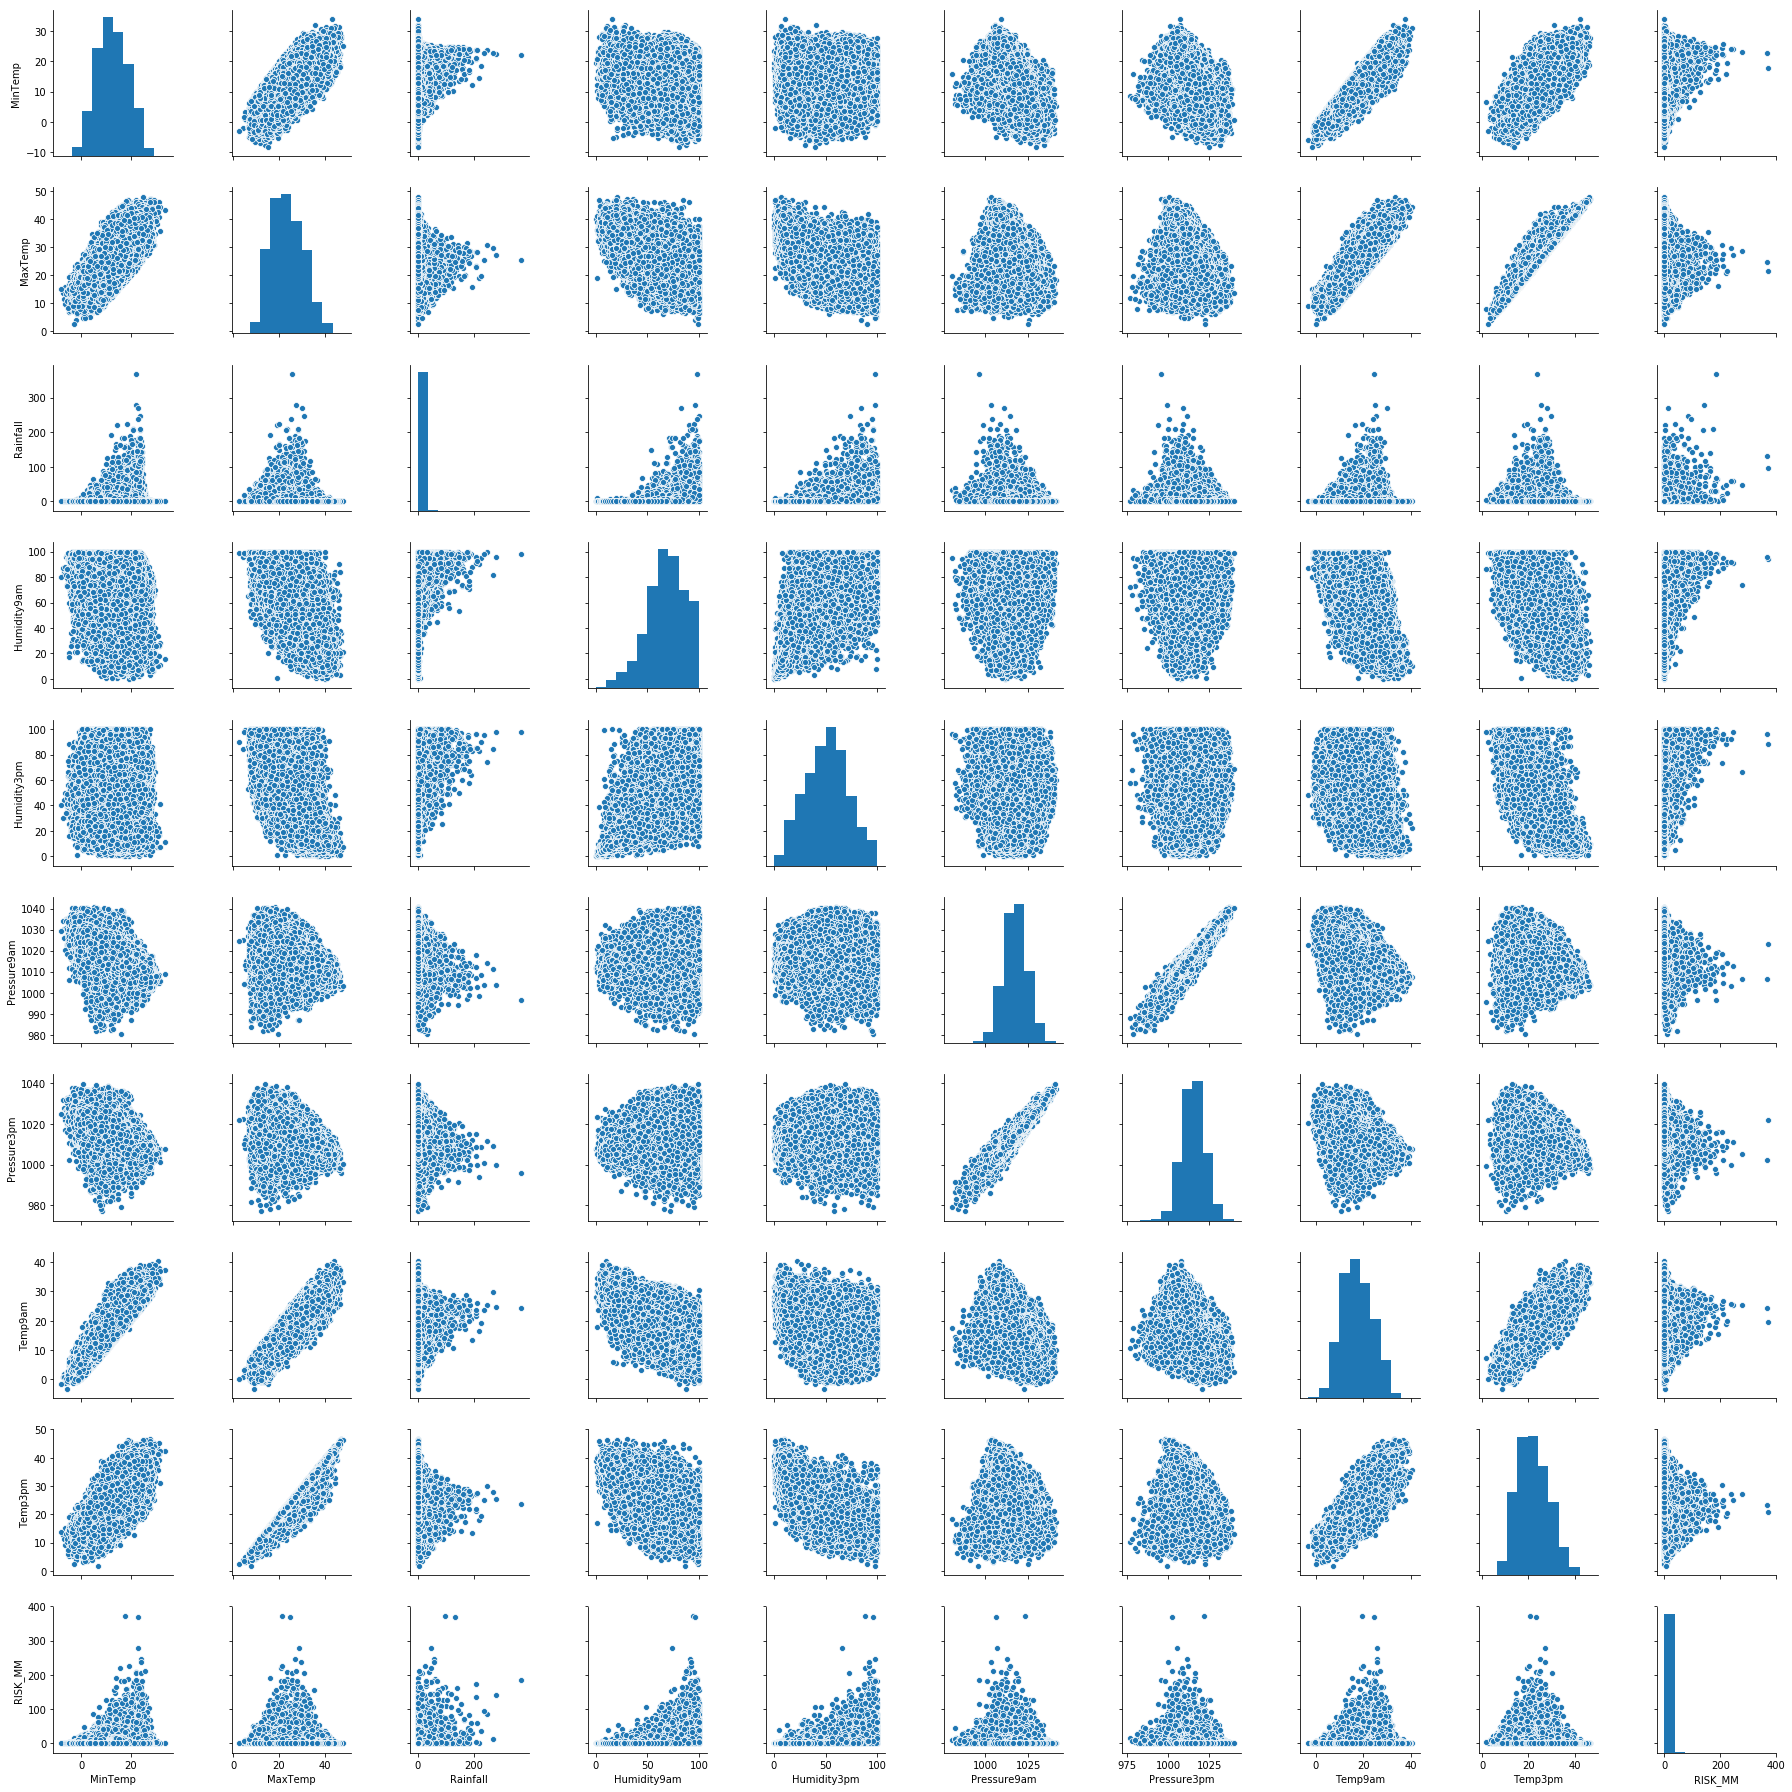

In [29]:
sns.pairplot(weather_all, size=2.5)
plt.tight_layout()
plt.show()

In [30]:
weather_all=weather_all.drop(columns=['RainToday','Rainfall'])

In [31]:
weather_all=weather_all.replace('Yes',1)
weather_all=weather_all.replace('No',0)

In [32]:
weather_all.head()

,MinTemp,MaxTemp,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RISK_MM,RainTomorrow
0,13.4,22.9,71.0,22.0,1007.7,1007.1,16.9,21.8,0.0,0
1,7.4,25.1,44.0,25.0,1010.6,1007.8,17.2,24.3,0.0,0
2,12.9,25.7,38.0,30.0,1007.6,1008.7,21.0,23.2,0.0,0
3,9.2,28.0,45.0,16.0,1017.6,1012.8,18.1,26.5,1.0,0
4,17.5,32.3,82.0,33.0,1010.8,1006.0,17.8,29.7,0.2,0


In [33]:
weather_all['RainTomorrow'].value_counts()

0    87906
1    25019
Name: RainTomorrow, dtype: int64

## PCA

从特征间相关系数得知有几列特征间有较高的线性关系，可以考虑使用PCA降维

In [34]:
X_train, X_test, y_train, y_test = train_test_split(weather_all[weather_all.columns.difference(['RISK_MM','RainTomorrow'])], weather_all['RainTomorrow'], test_size=0.33, random_state=42)

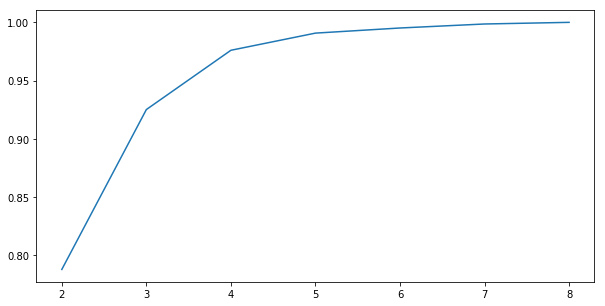

In [35]:
ratio=[]

for n in [2,3,4,5,6,7,8]:
    pipe_pca = make_pipeline(StandardScaler(),PCA(n_components=n))
    pipe_pca.fit(X_train)  
    ratio.append(np.sum(pipe_pca.named_steps['pca'].explained_variance_ratio_))
    
plt.figure(figsize=(10,5))
plt.plot([2,3,4,5,6,7,8],ratio)
plt.show()

PCA取前4个主成分，约解释97%的方差

### 逻辑回归

由于样本不平衡，在此先为样本寻找一个分配权重

Best parameters : {'logisticregression__class_weight': {0: 0.33421052631578946, 1: 0.6657894736842105}}


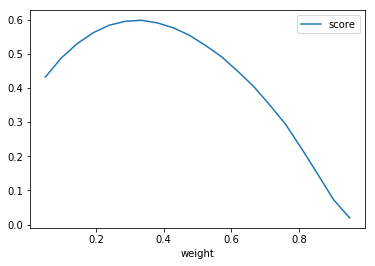

In [36]:
weights = np.linspace(0.05, 0.95, 20)
pipe_lr = make_pipeline(StandardScaler(),PCA(n_components=4),LogisticRegression())
gsc = GridSearchCV(
    estimator=pipe_lr,
    param_grid={
        'logisticregression__class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='f1',
    cv=10
)
grid_result = gsc.fit(X_train, y_train)

print("Best parameters : %s" % grid_result.best_params_)

# Plot the weights vs f1 score
dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
dataz.plot(x='weight')

In [37]:
pipe_lr = make_pipeline(StandardScaler(),PCA(n_components=4),LogisticRegression(class_weight={0: 0.33421052631578946, 1: 0.6657894736842105}))
pipe_lr.fit(X_train,y_train)
f1_score(pipe_lr.predict(X_test),y_test)

0.6020260492040521

In [38]:
print(classification_report(y_test, pipe_lr.predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88     28874
           1       0.59      0.62      0.60      8392

   micro avg       0.82      0.82      0.82     37266
   macro avg       0.74      0.75      0.74     37266
weighted avg       0.82      0.82      0.82     37266



In [39]:
pipe_lr.named_steps['logisticregression'].coef_

array([[-0.16899676,  1.10328732, -0.27162393, -0.46433009]])

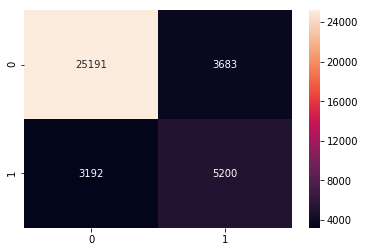

In [40]:
confMatrix = confusion_matrix(y_test, pipe_lr.predict(X_test))
sns.heatmap(confMatrix, annot=True, fmt="d")

### 线性回归

In [41]:
X_train, X_test, y_train, y_test = train_test_split(weather_all[weather_all.columns.difference(['RISK_MM','RainTomorrow'])], weather_all['RISK_MM'], test_size=0.33, random_state=42)
pipe_linr = make_pipeline(StandardScaler(),PCA(n_components=4),LinearRegression())
pipe_linr.fit(X_train,y_train)
y_pre=pipe_linr.predict(X_test)

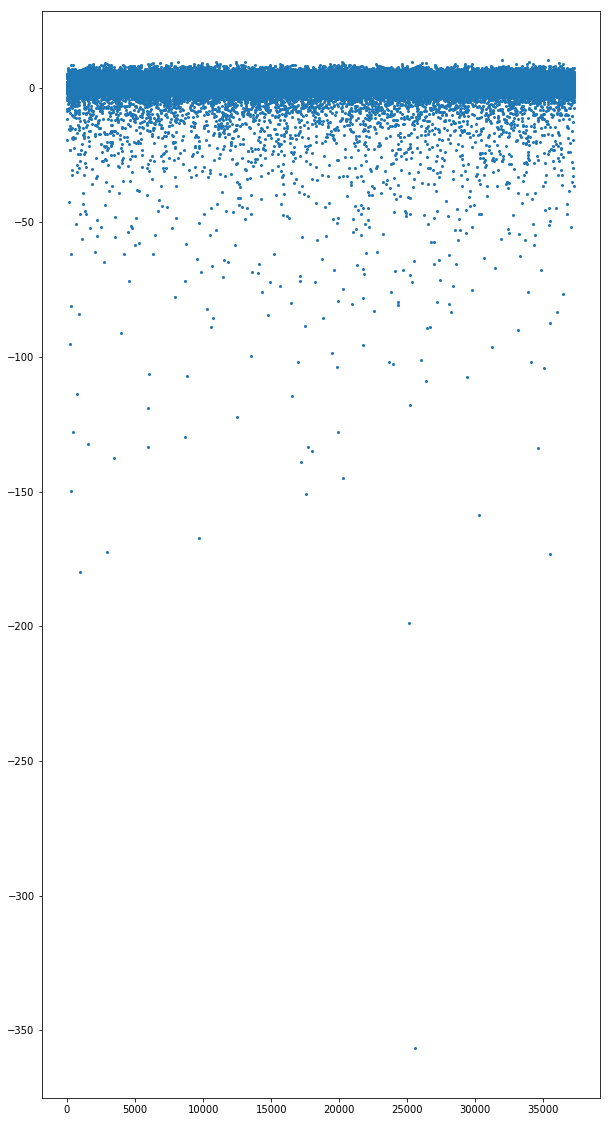

In [42]:
plt.figure(figsize=(10,20))
plt.scatter(range(len(X_test)),y_pre-y_test,s=4)
plt.show()

观测残差图，还是有少部分点分布在x轴下侧，点并没有均匀地分布在两侧，说明该模型对降水量的预测能力不强。

## Adaboost

In [43]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(weather_all[weather_all.columns.difference(['RISK_MM','RainTomorrow'])], weather_all['RainTomorrow'], test_size=0.33, random_state=42)
f1t=[]
f1a=[]
for n in range(1,50):
    bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),algorithm="SAMME",n_estimators=n)
    pipe_ada = make_pipeline(StandardScaler(),PCA(n_components=4),bdt)
    pipe_ada.fit(X_train, y_train)
    y_pret=pipe_ada.predict(X_test)
    y_prea=pipe_ada.predict(X_train)
    f1t.append(f1_score(y_pret,y_test))
    f1a.append(f1_score(y_prea,y_train))
    

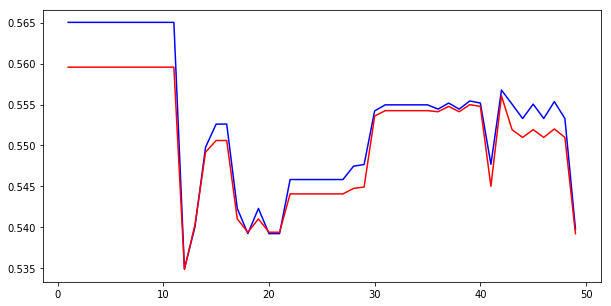

In [44]:
plt.figure(figsize=(10,5))
plt.plot(range(1,50),f1t,color='b')
plt.plot(range(1,50),f1a,color='r')
plt.show()

## 随机森林

In [46]:
from sklearn.ensemble import RandomForestClassifier
f1t=[]
f1a=[]
for n in range(1,100):
    pipe_rd = make_pipeline(RandomForestClassifier(n_estimators=n,max_depth=2))
    pipe_rd.fit(X_train, y_train)
    f1t.append(f1_score(y_test,pipe_rd.predict(X_test)))
    f1a.append(f1_score(y_train,pipe_rd.predict(X_train)))

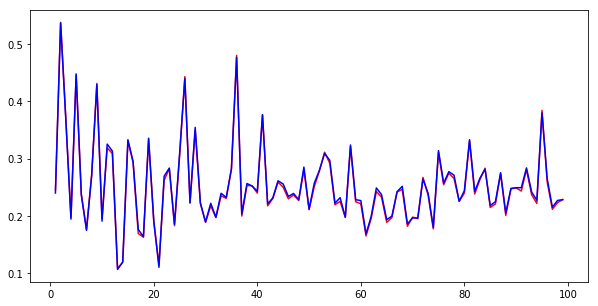

In [47]:
plt.figure(figsize=(10,5))
plt.plot(range(1,100),f1t,color='r')
plt.plot(range(1,100),f1a,color='b')
plt.show()

## 附录

### 线性回归（PCA）

查看变量间相关系数

In [48]:
weather_sydney=weather_sydney.drop(columns=['Rainfall','RainToday'])

In [49]:
weather_sydney.corr()

,MinTemp,MaxTemp,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
MinTemp,1.0000000,0.7648734,0.5648948,-0.0668020,0.1762963,-0.3155750,0.2348792,0.0348153,0.2664008,-0.4234145,...,-0.0474265,-0.0741448,-0.0644766,0.0430957,0.0282477,-0.1347058,-0.0761682,-0.1387002,-0.1348881,-0.1215947
MaxTemp,0.7648734,1.0000000,0.5035121,0.3202881,0.1176743,-0.3542884,0.1651011,-0.2154112,-0.1597932,-0.4076789,...,-0.0077922,-0.0224238,-0.1461224,-0.0207337,-0.0522085,-0.2225750,-0.0969231,-0.0894781,-0.0102061,-0.0951001
Evaporation,0.5648948,0.5035121,1.0000000,0.1910458,0.3106244,-0.0602685,0.3278335,-0.4251387,-0.1294311,-0.3602048,...,-0.0394794,-0.0677227,-0.0181989,0.0547526,0.0132564,-0.1201557,-0.0617931,-0.0557787,-0.0822595,0.0320871
Sunshine,-0.0668020,0.3202881,0.1910458,1.0000000,0.0044047,-0.0371320,0.2186688,-0.5129907,-0.5743622,-0.0441665,...,-0.0423739,-0.0021668,-0.1247992,-0.0951003,-0.1022702,-0.1761143,-0.0609162,0.0026708,0.0653287,0.0323586
WindGustSpeed,0.1762963,0.1176743,0.3106244,0.0044047,1.0000000,0.2712546,0.6056730,-0.3135669,-0.1542999,-0.5113344,...,-0.0016384,0.0785626,0.1345232,0.0068435,0.0513442,0.0948536,0.0932319,0.1136975,0.0824698,0.1724636
WindSpeed9am,-0.3155750,-0.3542884,-0.0602685,-0.0371320,0.2712546,1.0000000,0.1564442,-0.1973558,-0.1755167,0.0393669,...,-0.0274003,0.0222794,0.1665983,0.1008647,0.1355179,0.1385123,0.0937686,0.0732891,0.0491341,0.1160714
WindSpeed3pm,0.2348792,0.1651011,0.3278335,0.2186688,0.6056730,0.1564442,1.0000000,-0.3240160,-0.1516495,-0.3575584,...,-0.0306020,-0.0038370,0.0764520,-0.0294849,0.0919729,0.0252065,-0.0486716,0.0906179,-0.0172051,0.0978862
Humidity9am,0.0348153,-0.2154112,-0.4251387,-0.5129907,-0.3135669,-0.1973558,-0.3240160,1.0000000,0.6527226,0.2964959,...,0.0146720,-0.0558073,0.0508990,0.0069509,0.0611992,0.0856040,0.0021781,-0.1025273,-0.1402952,-0.1450245
Humidity3pm,0.2664008,-0.1597932,-0.1294311,-0.5743622,-0.1542999,-0.1755167,-0.1516495,0.6527226,1.0000000,0.1533589,...,-0.0264213,-0.1359829,0.0923468,0.0680985,0.1135199,0.1424216,-0.0108564,-0.2050969,-0.3040303,-0.2249119
Pressure9am,-0.4234145,-0.4076789,-0.3602048,-0.0441665,-0.5113344,0.0393669,-0.3575584,0.2964959,0.1533589,1.0000000,...,-0.0044055,-0.1055804,0.0454271,0.0397245,0.0326377,0.0783235,-0.0472876,-0.1532630,-0.1277989,-0.1182452


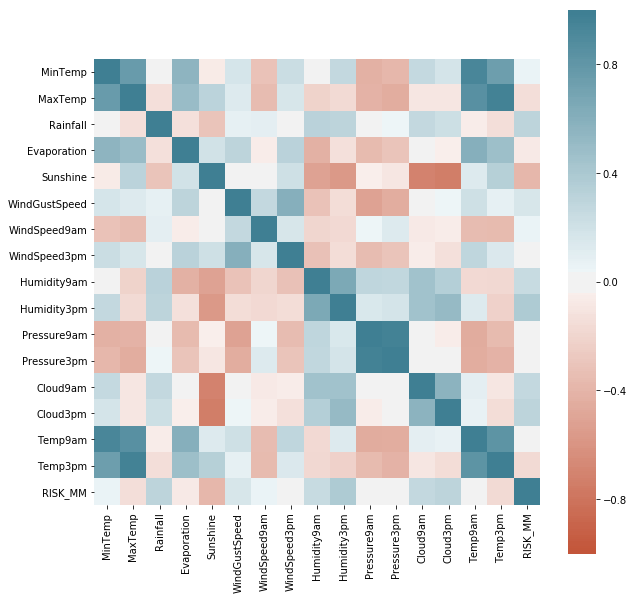

In [50]:

plt.figure(figsize=(10,10))
sns.heatmap(weather_sydney2.corr(), vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True)
plt.show()
 

### 线性回归（特征选择）

In [51]:
X_train, X_test, y_train, y_test = train_test_split(weather_sydney[weather_sydney.columns.difference(['RISK_MM','RainTomorrow'])], weather_sydney['RISK_MM'], test_size=0.33, random_state=42)

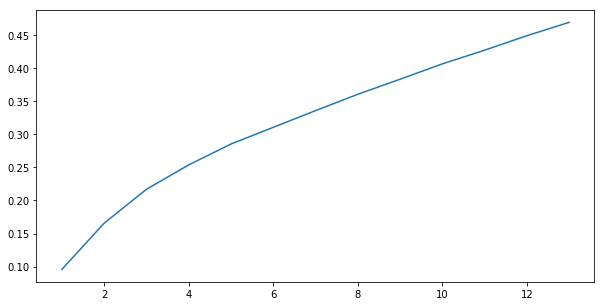

In [52]:
ratio=[]

for n in [1,2,3,4,5,6,7,8,9,10,11,12,13]:
    pipe_pca = make_pipeline(StandardScaler(),PCA(n_components=n))
    pipe_pca.fit(X_train)  
    ratio.append(np.sum(pipe_pca.named_steps['pca'].explained_variance_ratio_))
    
plt.figure(figsize=(10,5))
plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13],ratio)
plt.show()

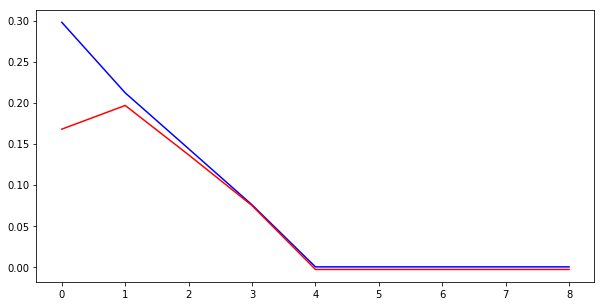

In [58]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso

r2t=[]
r2a=[]

for al in [0,1,2,3,4,5,6,7,8]:
    pipe_La= make_pipeline(StandardScaler(),Lasso(alpha=al))
    pipe_La.fit(X_train,y_train)
    r2t.append(r2_score(y_test,pipe_La.predict(X_test)))
    r2a.append(r2_score(y_train,pipe_La.predict(X_train)))
    
plt.figure(figsize=(10,5))
plt.plot([0,1,2,3,4,5,6,7,8],r2a,color='b')
plt.plot([0,1,2,3,4,5,6,7,8],r2t,color='r')
plt.show()

In [59]:
pipe_La= make_pipeline(StandardScaler(),Lasso(alpha=1))
pipe_La.fit(X_train,y_train)
coefficient=pd.DataFrame({'feature':X_train.columns,'coef_':pipe_La.named_steps['lasso'].coef_})
coefficient[coefficient['coef_']!=0]

,feature,coef_
3,Humidity3pm,1.8075166
9,Sunshine,-1.8567882
57,WindGustSpeed,0.8482483


In [ ]:
pipe_Lin= make_pipeline(StandardScaler(),LinearRegression())
pipe_Lin.fit(X_train,y_train)


## 逻辑回归

尝试仅预测是否下雨，即分类。这里我们使用逻辑回归。使用前先剔除掉数据集中记录明日降水量的‘RISK_MM’，并将‘RainTomorrow’作为预测对象。

In [61]:
X_train, X_test, y_train, y_test = train_test_split(weather_sydney[weather_sydney.columns.difference(['RISK_MM','RainTomorrow'])], weather_sydney['RainTomorrow'], test_size=0.33, random_state=42)

In [62]:
weather_sydney['RainTomorrow'].value_counts()

0    1276
1     416
Name: RainTomorrow, dtype: int64

数据类别有些不平衡，明显下雨天的样本过少。因此我们使用交叉验证法对类别权重进行调参。

Best parameters : {'logisticregression__class_weight': {0: 0.33421052631578946, 1: 0.6657894736842105}}


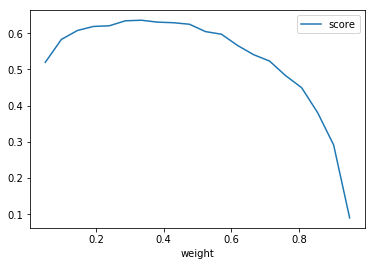

In [68]:
from sklearn.model_selection import GridSearchCV

weights = np.linspace(0.05, 0.95, 20)
pipe_Lo= make_pipeline(StandardScaler(),LogisticRegression(penalty='l1',C=0.5))
gsc = GridSearchCV(
    estimator=pipe_Lo,
    param_grid={
        'logisticregression__class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='f1',
    cv=10
)
grid_result = gsc.fit(X_train, y_train)

print("Best parameters : %s" % grid_result.best_params_)

# Plot the weights vs f1 score
dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
dataz.plot(x='weight')

In [ ]:
cv_results=pd.DataFrame(gsc.cv_results_)
cv_results

In [ ]:
index=np.where(gsc.cv_results_['rank_test_score']==1)
logmean=gsc.cv_results_['mean_test_score'][index]
logstd=gsc.cv_results_['std_test_score'][index]
log_score=cv_results.loc[4,['split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'split4_test_score',
       'split5_test_score', 'split6_test_score', 'split7_test_score',
       'split8_test_score', 'split9_test_score']]

In [ ]:
index

In [ ]:
print('mean_score:',logmean)
print('std_score:',logstd)

In [ ]:
gsc.best_estimator_

In [ ]:
gsc.best_score_

在权重为0.2时模型得分最高。f1值约为0.63。

In [ ]:
y_pre=LogisticRegression(class_weight={0: 0.2, 1: 0.8}).fit(X_train,y_train).predict(X_test)
f1_score(y_test,y_pre)

训练得到的模型在测试集上的F1为0.62

## 决策树

In [70]:
X_train, X_test, y_train, y_test = train_test_split(weather_sydney[weather_sydney.columns.difference(['RainTomorrow','RISK_MM'])], weather_sydney['RainTomorrow'], test_size=0.33, random_state=42)

Best parameters : {'max_depth': 8}


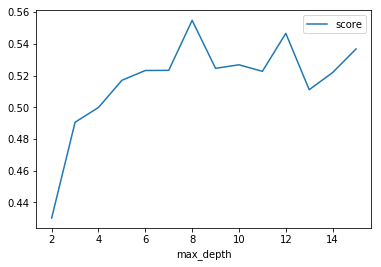

In [71]:
gsc = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid={
        'max_depth': [2,3,4,5,6,7,8,9,10,11,12,13,14,15]
    },
    scoring='f1',
    cv=10
)
grid_result = gsc.fit(X_train, y_train)

print("Best parameters : %s" % grid_result.best_params_)


dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                       'max_depth': [2,3,4,5,6,7,8,9,10,11,12,13,14,15] })
dataz.plot(x='max_depth')

可见‘max_depth’取8时较为合适。

In [ ]:
cv_results=pd.DataFrame(gsc.cv_results_)


In [ ]:
index=np.where(gsc.cv_results_['rank_test_score']==1)
frmean=gsc.cv_results_['mean_test_score'][index]
frstd=gsc.cv_results_['std_test_score'][index]
fr_score=cv_results.loc[3,['split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'split4_test_score',
       'split5_test_score', 'split6_test_score', 'split7_test_score',
       'split8_test_score', 'split9_test_score']]

In [ ]:
print('mean_score:',frmean)
print('std_score:',frstd)

In [ ]:
dtree=DecisionTreeClassifier(max_depth=7)
dtree.fit(X_train,y_train)
f1_score(dtree.predict(X_test),y_test)

#f1_score(y_test,y_pre)

### 随机森林

In [ ]:
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(weather_sydney[weather_sydney.columns.difference(['RainToday','RainTomorrow','RISK_MM'])], weather_sydney['RainTomorrow'], test_size=0.33, random_state=42)
clf = RandomForestClassifier(n_estimators=10000, max_depth=11,random_state=0)
clf.fit(X_train,y_train)
f1_score(clf.predict(X_test),y_test)

## 假设检验

从结果上看似乎逻辑回归模型f1值更高，记逻辑回归的f1值为$F1_log$,决策树模型的f1值为$F1_fr$。现在我们提出如下假设：
$H_0:F1_{log}=F1_{fr}$
$H_1:F1_{log}>F1_{fr}$

In [ ]:
from scipy import stats


In [ ]:
stats.mstats.ttest_ind(log_score,fr_score).pvalue<0.5

拒绝原假设，可认为逻辑回归的f1值高于决策树模型。